In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dropout, Dense, Concatenate, Lambda, BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers.legacy import SGD, Adam
import keras.backend as K
from keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
from data.data_frame_loader import DataFrameLoader

In [8]:
df_personas, df_trabajadores, df_usuarios, df_peliculas, df_scores = DataFrameLoader.load_all("csv_files/personas.csv","csv_files/trabajadores.csv","csv_files/usuarios.csv","csv_files/peliculas.csv","csv_files/scores.csv")

c:\Users\agust\OneDrive\Desktop\Facu\DeepLearning\DeepLearning2023_TP2_Gr1\data\data_frame_loader.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Release Date"] = pd.to_datetime(df["Release Date"], format="%d-%b-%Y")


In [9]:
u_unique = df_scores.user_id.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}  #Reindexa el ID del usuario

m_unique = df_scores.movie_id.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)} #Reindexa el ID de la pelicula
idx2Movie = {v:k for k,v in movie2Idx.items()}

df_peliculas.head()

,id,Name,Release Date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995-01-01,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995-01-01,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995-01-01,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on,
                      suffixes=("", "_y"))

df_scores = join_df(df_scores, df_peliculas, "movie_id", "id")

In [11]:
df_scores.head()

,id,user_id,movie_id,rating,Date,id_y,Name,Release Date,IMDB URL,unknown,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,196,242,3,1997-12-04 15:55:49,242,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,...,0,0,0,0,0,0,0,0,0,0
1,1,186,302,3,1998-04-04 19:22:22,302,L.A. Confidential (1997),1997-01-01,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,...,0,1,0,0,1,0,0,1,0,0
2,2,22,377,1,1997-11-07 07:18:36,377,Heavyweights (1994),1994-01-01,http://us.imdb.com/M/title-exact?Heavyweights%...,0,...,0,0,0,0,0,0,0,0,0,0
3,3,244,51,2,1997-11-27 05:02:03,51,Legends of the Fall (1994),1994-01-01,http://us.imdb.com/M/title-exact?Legends%20of%...,0,...,0,0,0,0,0,1,0,0,1,1
4,4,166,346,1,1998-02-02 05:33:16,346,Jackie Brown (1997),1997-01-01,http://us.imdb.com/M/title-exact?imdb-title-11...,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_scores.user_id = df_scores.user_id.apply(lambda x: user2Idx[x])
df_scores.movie_id = df_scores.movie_id.apply(lambda x: movie2Idx[x])

In [13]:
df_scores_train, df_scores_val = train_test_split(df_scores, test_size=0.2)
#Ponemos seed?

In [14]:
#Agregar Unknow

genre = ['Action', 'Adventure', 'Animation',
              "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
              'Thriller', 'War', 'Western']

In [15]:

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [22]:


#https://code-first-ml.github.io/book1/notebooks/recommender_systems/2017-12-18-recommend-keras.html

# Definir las dimensiones de los datos
n_users = int(df_scores.user_id.nunique())
n_movies = int(df_scores.movie_id.nunique())
n_users_train = int(df_scores_train.user_id.nunique())
n_movies_train = int(df_scores_train.movie_id.nunique())
n_genre = len(genre)
print(f"Usuarios: {n_users}\nPeliculas: {n_movies} \nUsuarios Train:{n_users_train} \nPeliculas Train: {n_movies_train}")

#Bajar un poco los numeros ---> Usuarios son la mitad
n_latent_factors_movie = 20  # Número de factores latentes para películas
n_latent_factors_user = 20   # Número de factores latentes para usuarios

max_rating = df_scores_train['rating'].max()
min_rating = df_scores_train['rating'].min()
av_rating = df_scores_train['rating'].mean()

# Definir el optimizador
opt = SGD(learning_rate=0.01)

# Definir las entradas
genre_input = Input(shape=[n_genre], name='genre')
movie_input = Input(shape=[1], name='Item')
user_input = Input(shape=[1], name='User')

# Capa de embedding para películas con regularización L2
movie_embedding = Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding', embeddings_regularizer=l2(0.01))(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

# Capa de embedding para usuarios con regularización L2
user_embedding = Embedding(n_users + 1, n_latent_factors_user, name='User-Embedding', embeddings_regularizer=l2(0.01))(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)

# Concatenar las características
concat = Concatenate(name='Concat')([movie_vec, user_vec, genre_input])

# Capas ocultas con regularización L2, dropout y peso máximo (max_norm)
x = Dense(90, activation='relu', name='Hidden1', kernel_regularizer=l2(0.0001), kernel_constraint=max_norm(2))(concat)
x = Dropout(0.3)(x)
x = Dense(120, activation='relu', name='Hidden2', kernel_regularizer=l2(0.0001), kernel_constraint=max_norm(2))(x)
x = Dropout(0.3)(x)
x = Dense(90, activation='relu', name='Hidden3', kernel_regularizer=l2(0.0001), kernel_constraint=max_norm(2))(x)
x = Dropout(0.2)(x)

# Capa de salida
output = Dense(1, activation='relu', name='Activation')(x)

# Crear el modelo
model = Model([user_input, movie_input, genre_input], output)

# Compilar el modelo para regresión
model.compile(optimizer=opt, loss='mean_squared_error', metrics=[RootMeanSquaredError()])

checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True, monitor='val_root_mean_squared_error')

# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, verbose=1)

# Definir ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_root_mean_squared_error', factor=0.1, patience=4, min_lr=1e-8, verbose=1)

# Resumen del modelo
model.summary()


Usuarios: 943
Peliculas: 1682 
Usuarios Train:943 
Peliculas Train: 1642
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Item (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 User (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Movie-Embedding (Embedding  (None, 1, 20)                33660     ['Item[0][0]']                
 )                                                                                                
                                                                                                  
 User-Embedding (Em

In [23]:
batch_size=150
epochs=300

# Entrenar el modelo
history = model.fit(
    [df_scores_train.user_id, df_scores_train.movie_id, df_scores_train[genre]],
    df_scores_train.rating,
    validation_data=([df_scores_val.user_id, df_scores_val.movie_id, df_scores_val[genre]], df_scores_val.rating),
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    callbacks=[early_stopping, checkpointer, reduce_lr]
)


Epoch 1/300

Epoch 1: val_root_mean_squared_error improved from inf to 1.10928, saving model to weights.hdf5
534/534 - 6s - loss: 1.9948 - root_mean_squared_error: 1.2528 - val_loss: 1.6147 - val_root_mean_squared_error: 1.1093 - lr: 0.0100 - 6s/epoch - 10ms/step
Epoch 2/300


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_root_mean_squared_error improved from 1.10928 to 1.10652, saving model to weights.hdf5
534/534 - 3s - loss: 1.6405 - root_mean_squared_error: 1.1365 - val_loss: 1.5402 - val_root_mean_squared_error: 1.1065 - lr: 0.0100 - 3s/epoch - 5ms/step
Epoch 3/300

Epoch 3: val_root_mean_squared_error did not improve from 1.10652
534/534 - 3s - loss: 1.5542 - root_mean_squared_error: 1.1255 - val_loss: 1.4931 - val_root_mean_squared_error: 1.1101 - lr: 0.0100 - 3s/epoch - 5ms/step
Epoch 4/300

Epoch 4: val_root_mean_squared_error improved from 1.10652 to 1.10269, saving model to weights.hdf5
534/534 - 4s - loss: 1.4886 - root_mean_squared_error: 1.1183 - val_loss: 1.4326 - val_root_mean_squared_error: 1.1027 - lr: 0.0100 - 4s/epoch - 8ms/step
Epoch 5/300

Epoch 5: val_root_mean_squared_error improved from 1.10269 to 1.09839, saving model to weights.hdf5
534/534 - 3s - loss: 1.4403 - root_mean_squared_error: 1.1144 - val_loss: 1.3877 - val_root_mean_squared_error: 1.0984 - lr: 0.0100 

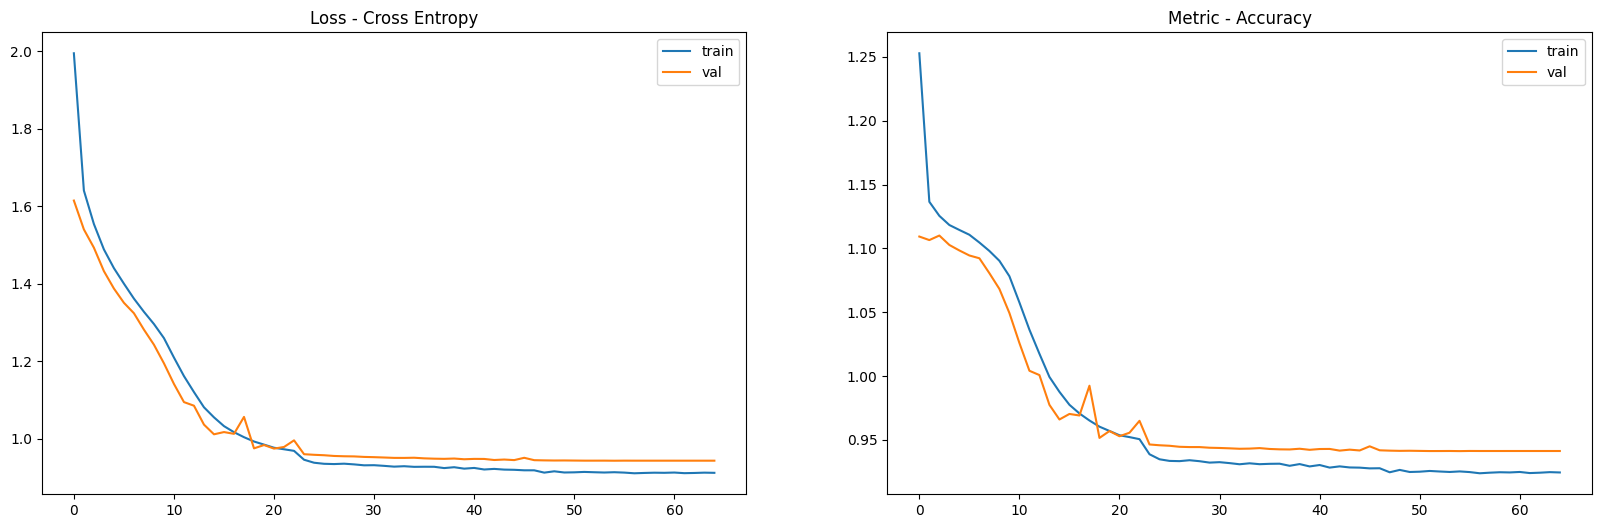

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(model.history.history['loss'], label='train')
ax1.plot(model.history.history['val_loss'], label='val')
ax1.set_title('Loss - Cross Entropy')
ax1.legend()
ax2.plot(model.history.history['root_mean_squared_error'], label='train')
ax2.plot(model.history.history['val_root_mean_squared_error'], label='val')
ax2.set_title('Metric - Accuracy')
ax2.legend()
plt.show()

In [25]:
model.evaluate([df_scores_val.user_id, df_scores_val.movie_id, df_scores_val[genre]], df_scores_val.rating)




625/625 [==============================] - 2s 3ms/step - loss: 0.9434 - root_mean_squared_error: 0.9413


[0.9433679580688477, 0.9413261413574219]

In [26]:
model.load_weights('weights.hdf5')
model.evaluate([df_scores_val.user_id, df_scores_val.movie_id, df_scores_val[genre]], df_scores_val.rating)

625/625 [==============================] - 1s 2ms/step - loss: 0.9433 - root_mean_squared_error: 0.9412


[0.9432798624038696, 0.9412449598312378]

# Embeddings

In [16]:
movie_embeddings_layer = model.layers[2]
user_embeddings_layer = model.layers[3]

In [17]:
movie_embeddings_layer.name, user_embeddings_layer.name

('Movie-Embedding', 'User-Embedding')

In [18]:
movie_embeddings_matrix = movie_embeddings_layer.get_weights()[0]
user_embeddings_matrix = user_embeddings_layer.get_weights()[0]
movie_embeddings_matrix[0], user_embeddings_matrix.shape

(array([ 6.9691852e-04,  6.9132878e-04, -9.7433920e-04,  7.1175699e-04,
         9.4077759e-04, -3.4237819e-04,  8.0289308e-04, -7.8987301e-04,
        -6.2204752e-05,  4.7628334e-04,  7.7761113e-05, -5.4751860e-04,
        -7.0846680e-04, -6.8318006e-04,  8.8423863e-04, -8.8081579e-04,
         8.1089546e-04, -1.0470210e-03,  9.9037495e-04, -1.2263290e-04],
       dtype=float32),
 (944, 20))

In [19]:
model_test_emb = Model([movie_input], [movie_embedding])

In [21]:
index = 424 #6
movie_embed = model_test_emb.predict([index])
df_peliculas.loc[idx2Movie[index]].name

1/1 [==============================] - 0s 433ms/step


70

In [ ]:
"""
np.save('vectors/movie_embeddings_matrix.npy', movie_embeddings_matrix)
np.save('vectors/user_embeddings_matrix.npy', user_embeddings_matrix)
np.save('vectors/user2Idx.npy', user2Idx)
np.save('vectors/movie2Idx.npy', movie2Idx)
"""